In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
%matplotlib inline

In [47]:
mortgage = pd.read_csv('mortgage_data.csv')
auction = pd.read_csv('auction_data.csv')

In [74]:
mortgage.head()


,loan_index,property_value,house_indicator,credit_score,married,num_dependents,annual_income,coapplicant_indicator,coapplicant_income,interest_rate,...,default_30,total_cash_flow,relative_cash_flow,years_of_cashflow,adjusted_income,edu_Began Bachelors,edu_Graduate Degree,edu_High School,predicted_default_probability,predicted_default_category
0,0,1034333.55,1,689,0,0,183896.81,0,0.00,7.08,...,0.0,2016578.10,1.00,30.0,183896.810,False,False,False,0.148199,0.0
1,1,942811.10,1,620,0,0,182878.90,1,155627.09,7.25,...,0.0,1869472.80,1.00,30.0,229567.027,False,False,False,0.170971,0.0
2,2,438038.56,1,722,1,1,70405.18,0,0.00,7.00,...,1.0,197679.72,0.23,7.0,70405.180,True,False,False,0.436556,0.0
3,3,992154.42,1,636,1,2,135044.99,1,118209.66,7.21,...,1.0,1110404.81,0.57,17.0,170507.888,False,False,True,0.609402,1.0
4,4,628359.44,1,620,1,1,99933.09,0,0.00,7.25,...,0.0,1245955.50,1.00,30.0,99933.090,False,False,True,0.779249,1.0


In [77]:
def presentValueFixed (annuity):
    presentValue = 0
    for i in range(1, 31):
        presentValue += (annuity / pow((1 + 0.044), i))
    return presentValue

def presentValueVariable(annuity, default_probs, rate=0.044):
    presentValue = 0
    for i in range(1, 31):
        adjusted_annuity = annuity * (1 - default_probs[i-1])
        presentValue += (adjusted_annuity / pow((1 + rate), i))
    return presentValue

def calcPresentValueSimpleDefault(df, rate=0.044):
    for index, row in df.iterrows():
        presentValue = 0
        presentValueDefault= 0
        annuity = row['pmt']
        adjusted_annuity = annuity * (1 - row['predicted_default_probability'])
        for i in range(1, 31):
            presentValueDefault += (adjusted_annuity / pow((1 + rate), i))
            presentValue += (annuity / pow((1 + rate), i))
        df.loc[index, 'presentValueSimpleDefault'] = presentValueDefault
        df.loc[index, 'presentValue'] = presentValue


        

print(f"assuming that the default probability is zero the maximum bid should be ${presentValueFixed (67000):.2f}")
calcPresentValueSimpleDefault(mortgage)


assuming that the default probability is zero the maximum bid should be $1104312.35
reg annuity 67219.27---adjusted annuity 57257.466565358045
reg annuity 62315.76---adjusted annuity 51661.55908768529
reg annuity 28239.96---adjusted annuity 15911.629407484528
reg annuity 65317.93---adjusted annuity 25513.070093879356
reg annuity 41531.85---adjusted annuity 9168.214993953017
reg annuity 39425.27---adjusted annuity 16417.56256697189
reg annuity 46952.85---adjusted annuity 33849.29361096191
reg annuity 69558.64---adjusted annuity 12408.279748840088
reg annuity 39583.38---adjusted annuity 21878.84691062245
reg annuity 46351.26---adjusted annuity 18736.845961825562
reg annuity 26908.38---adjusted annuity 20453.889188352183
reg annuity 65338.1---adjusted annuity 20095.01567342021
reg annuity 45825.41---adjusted annuity 43480.6986295613
reg annuity 27055.08---adjusted annuity 26048.723455054944
reg annuity 27947.64---adjusted annuity 15701.201635237607
reg annuity 34187.59---adjusted annuity 

In [82]:
mortgage['simple_default_profit'] = mortgage['presentValue'] - mortgage['presentValueSimpleDefault'] 
total_profit_simple_default = mortgage['simple_default_profit'].sum()
print (total_profit_simple_default)

1165778239.924273


In [48]:
mortgage.columns.values

array(['loan_index', 'property_value', 'house_indicator', 'credit_score',
       'married', 'num_dependents', 'education', 'annual_income',
       'coapplicant_indicator', 'coapplicant_income', 'interest_rate',
       'pmt', 'pmt_1', 'pmt_2', 'pmt_3', 'pmt_4', 'pmt_5', 'pmt_6',
       'pmt_7', 'pmt_8', 'pmt_9', 'pmt_10', 'pmt_11', 'pmt_12', 'pmt_13',
       'pmt_14', 'pmt_15', 'pmt_16', 'pmt_17', 'pmt_18', 'pmt_19',
       'pmt_20', 'pmt_21', 'pmt_22', 'pmt_23', 'pmt_24', 'pmt_25',
       'pmt_26', 'pmt_27', 'pmt_28', 'pmt_29', 'pmt_30'], dtype=object)

### default column

In [49]:
# mortgage defaulted
# if any of the pmt columns have 0 in them 
pmt_columns = [f'pmt_{year}' for year in range(1, 31)]
mortgage['default'] = mortgage[pmt_columns].apply(lambda row: 1 if any(row == 0) else 0, axis=1)

### deafult per year


In [50]:
for index, row in mortgage.iterrows():
    for col in pmt_columns:
        year =  col.split('_')[1]
        mortgage.at[index, f'default_{year}'] = 1 if row[col] == 0 else 0
mortgage.head()

,loan_index,property_value,house_indicator,credit_score,married,num_dependents,education,annual_income,coapplicant_indicator,coapplicant_income,...,default_21,default_22,default_23,default_24,default_25,default_26,default_27,default_28,default_29,default_30
0,0,1034333.55,1,689,0,0,Bachelors Degree,183896.81,0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,942811.10,1,620,0,0,Bachelors Degree,182878.90,1,155627.09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,438038.56,1,722,1,1,Began Bachelors,70405.18,0,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,3,992154.42,1,636,1,2,High School,135044.99,1,118209.66,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,4,628359.44,1,620,1,1,High School,99933.09,0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Relative cash flow of mortgage

In [51]:
mortgage['total_cash_flow'] = mortgage[pmt_columns].sum(axis=1)
mortgage['relative_cash_flow'] = mortgage['total_cash_flow'] / (mortgage['pmt']*30)
mortgage['relative_cash_flow'] = mortgage['relative_cash_flow'].round(decimals=2)

### Number of years of cashflow

In [52]:
for index, row in mortgage.iterrows():
    for col in reversed(pmt_columns):
        if row[col] != 0:
            mortgage.at[index, 'years_of_cashflow'] = int(col.split('_')[1])
            break
mortgage.fillna(0, inplace=True)


### Adjusted income based on cosigner

In [53]:
mortgage[['coapplicant_income']] = mortgage[['coapplicant_income']].fillna(value=0)
mortgage['adjusted_income'] = mortgage['annual_income'] + 0.3 * mortgage['coapplicant_income']

In [54]:
mortgage.head()

,loan_index,property_value,house_indicator,credit_score,married,num_dependents,education,annual_income,coapplicant_indicator,coapplicant_income,...,default_25,default_26,default_27,default_28,default_29,default_30,total_cash_flow,relative_cash_flow,years_of_cashflow,adjusted_income
0,0,1034333.55,1,689,0,0,Bachelors Degree,183896.81,0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,2016578.10,1.00,30.0,183896.810
1,1,942811.10,1,620,0,0,Bachelors Degree,182878.90,1,155627.09,...,0.0,0.0,0.0,0.0,0.0,0.0,1869472.80,1.00,30.0,229567.027
2,2,438038.56,1,722,1,1,Began Bachelors,70405.18,0,0.00,...,1.0,1.0,1.0,1.0,1.0,1.0,197679.72,0.23,7.0,70405.180
3,3,992154.42,1,636,1,2,High School,135044.99,1,118209.66,...,1.0,1.0,1.0,1.0,1.0,1.0,1110404.81,0.57,17.0,170507.888
4,4,628359.44,1,620,1,1,High School,99933.09,0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,1245955.50,1.00,30.0,99933.090


### Let's do some analysis to see the effect of different variables on defaults

### Histrogram (income vs default count)

In [55]:
default_mortgage = mortgage[mortgage['default'] == 1]
no_default_mortgage = mortgage[mortgage['default'] == 0]

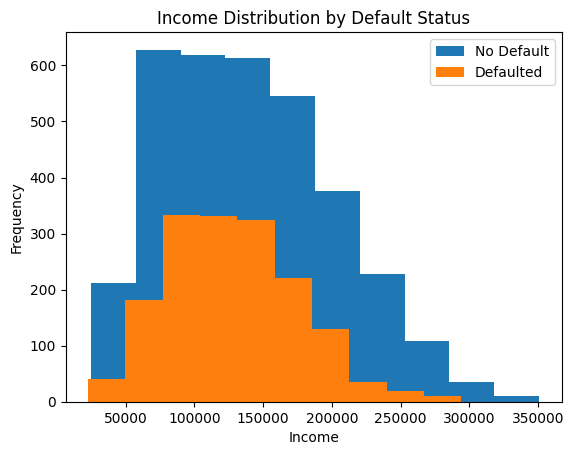

In [56]:
plt.hist(no_default_mortgage['annual_income'], bins=10, alpha=1, label='No Default')
plt.hist(default_mortgage['annual_income'], bins=10, alpha=1, label='Defaulted')

plt.xlabel('Income')
plt.ylabel('Frequency')
plt.title('Income Distribution by Default Status')
plt.legend()

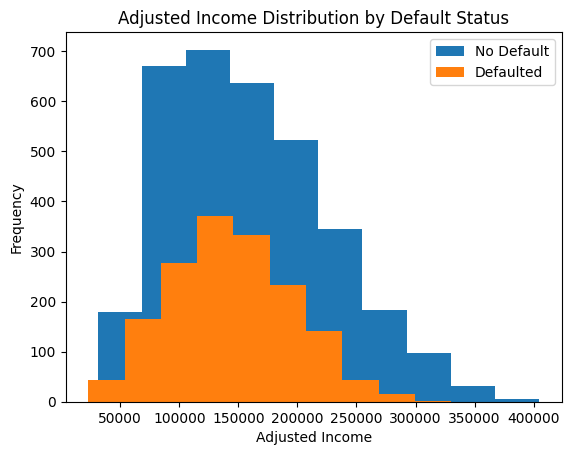

In [57]:
plt.hist(no_default_mortgage['adjusted_income'], bins=10, alpha=1, label='No Default')
plt.hist(default_mortgage['adjusted_income'], bins=10, alpha=1, label='Defaulted')

plt.xlabel('Adjusted Income')
plt.ylabel('Frequency')
plt.title('Adjusted Income Distribution by Default Status')
plt.legend()

### Scatter Plot of Annual Income vs the relative total cash flow

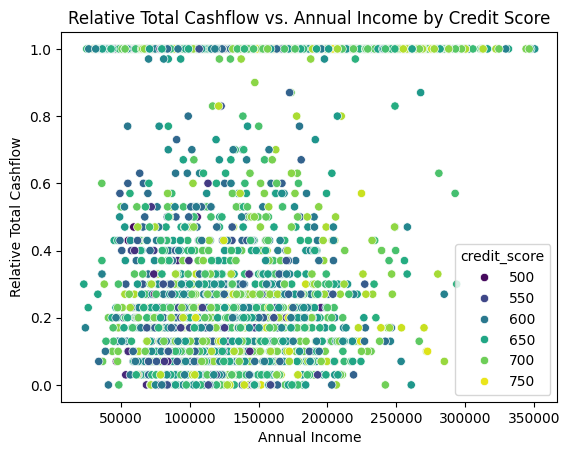

In [58]:
sns.scatterplot(data=mortgage, x='annual_income', y='relative_cash_flow', hue='credit_score', palette='viridis')
plt.title('Relative Total Cashflow vs. Annual Income by Credit Score')
plt.xlabel('Annual Income')
plt.ylabel('Relative Total Cashflow')
plt.show()

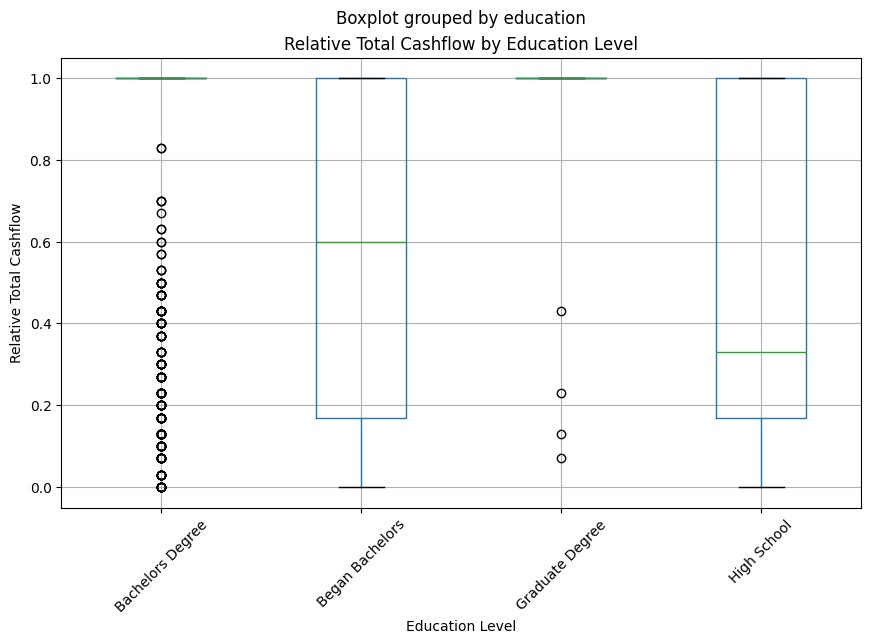

In [59]:
mortgage.boxplot(column='relative_cash_flow', by='education', figsize=(10,6))
plt.title('Relative Total Cashflow by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Relative Total Cashflow')
plt.xticks(rotation=45)  # Rotate labels to avoid overlap
plt.show()

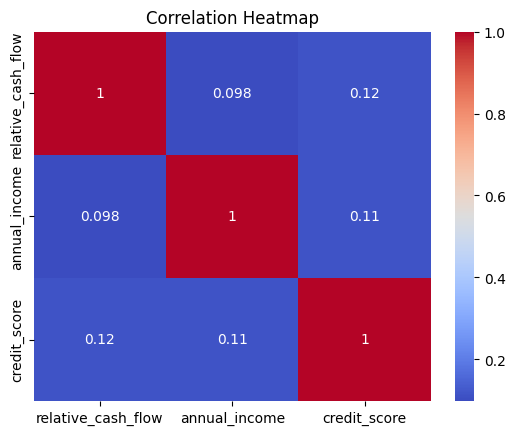

In [60]:

# Selecting a subset of variables to analyze
subset_df = mortgage[['relative_cash_flow', 'annual_income', 'credit_score']]

# Calculating correlations
corr = subset_df.corr()

# Plotting heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


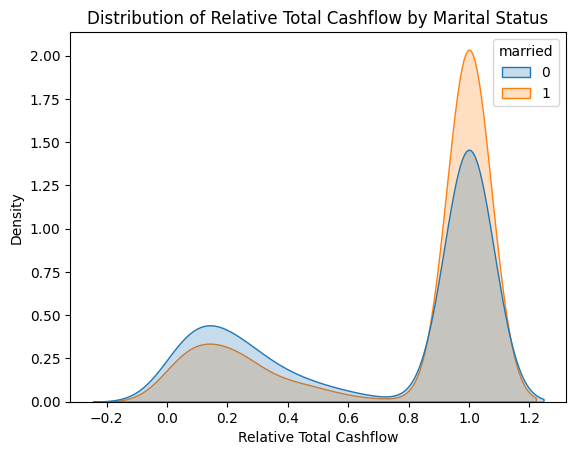

In [61]:
sns.kdeplot(data=mortgage, x='relative_cash_flow', hue='married', fill=True)
plt.title('Distribution of Relative Total Cashflow by Marital Status')
plt.xlabel('Relative Total Cashflow')
plt.ylabel('Density')
plt.show()

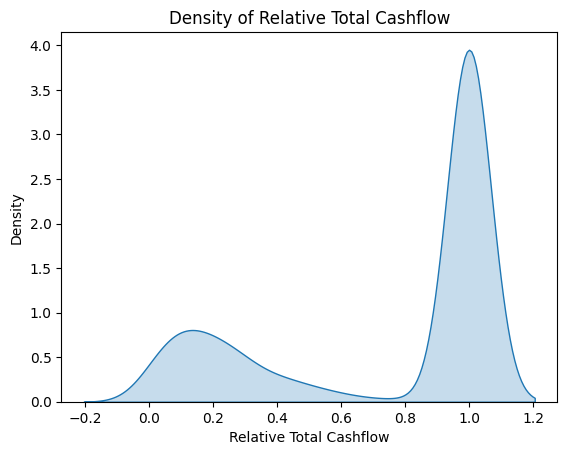

In [62]:
sns.kdeplot(data=mortgage['relative_cash_flow'], fill=True)
plt.title('Density of Relative Total Cashflow')
plt.xlabel('Relative Total Cashflow')
plt.ylabel('Density')
plt.show()

In [63]:
mortgage.columns.values

array(['loan_index', 'property_value', 'house_indicator', 'credit_score',
       'married', 'num_dependents', 'education', 'annual_income',
       'coapplicant_indicator', 'coapplicant_income', 'interest_rate',
       'pmt', 'pmt_1', 'pmt_2', 'pmt_3', 'pmt_4', 'pmt_5', 'pmt_6',
       'pmt_7', 'pmt_8', 'pmt_9', 'pmt_10', 'pmt_11', 'pmt_12', 'pmt_13',
       'pmt_14', 'pmt_15', 'pmt_16', 'pmt_17', 'pmt_18', 'pmt_19',
       'pmt_20', 'pmt_21', 'pmt_22', 'pmt_23', 'pmt_24', 'pmt_25',
       'pmt_26', 'pmt_27', 'pmt_28', 'pmt_29', 'pmt_30', 'default',
       'default_1', 'default_2', 'default_3', 'default_4', 'default_5',
       'default_6', 'default_7', 'default_8', 'default_9', 'default_10',
       'default_11', 'default_12', 'default_13', 'default_14',
       'default_15', 'default_16', 'default_17', 'default_18',
       'default_19', 'default_20', 'default_21', 'default_22',
       'default_23', 'default_24', 'default_25', 'default_26',
       'default_27', 'default_28', 'default_29',

In [64]:
mortgage = pd.get_dummies(mortgage, columns=['education'], prefix='edu', drop_first=True)

In [65]:
mortgage.head()

,loan_index,property_value,house_indicator,credit_score,married,num_dependents,annual_income,coapplicant_indicator,coapplicant_income,interest_rate,...,default_28,default_29,default_30,total_cash_flow,relative_cash_flow,years_of_cashflow,adjusted_income,edu_Began Bachelors,edu_Graduate Degree,edu_High School
0,0,1034333.55,1,689,0,0,183896.81,0,0.00,7.08,...,0.0,0.0,0.0,2016578.10,1.00,30.0,183896.810,False,False,False
1,1,942811.10,1,620,0,0,182878.90,1,155627.09,7.25,...,0.0,0.0,0.0,1869472.80,1.00,30.0,229567.027,False,False,False
2,2,438038.56,1,722,1,1,70405.18,0,0.00,7.00,...,1.0,1.0,1.0,197679.72,0.23,7.0,70405.180,True,False,False
3,3,992154.42,1,636,1,2,135044.99,1,118209.66,7.21,...,1.0,1.0,1.0,1110404.81,0.57,17.0,170507.888,False,False,True
4,4,628359.44,1,620,1,1,99933.09,0,0.00,7.25,...,0.0,0.0,0.0,1245955.50,1.00,30.0,99933.090,False,False,True


# Data

## Simple Default Data

In [66]:
simple_deafult_feature_cols = ['property_value', 'house_indicator', 'credit_score', 'married', 'num_dependents', 'coapplicant_indicator', 'interest_rate', 'pmt', 'adjusted_income']
simple_deafult_feature_cols += ['edu_Began Bachelors', 'edu_Graduate Degree', 'edu_High School']
X_simple_default = mortgage[simple_deafult_feature_cols]
y_simple_deafult = mortgage['default']
X_simple_default_train, X_simple_default_test, y_simple_default_train, y_simple_default_test = train_test_split(X_simple_default, y_simple_deafult, test_size=0.2, random_state=42)

## Yearly Default Data

In [67]:
yearly_default_feature_cols = ['property_value', 'house_indicator', 'credit_score', 'married', 'num_dependents', 'coapplicant_indicator', 'interest_rate', 'pmt', 'adjusted_income']
yearly_default_feature_cols += ['edu_Began Bachelors', 'edu_Graduate Degree', 'edu_High School'] 
yearly_default_output_cols = [f"default_{year}" for year in range(1, 31)]
X_yearly_default = mortgage[yearly_default_feature_cols]
y_yearly_deafult = mortgage[yearly_default_output_cols]
X_yearly_default_train, X_yearly_default_test, y_yearly_default_train, y_yearly_default_test = train_test_split(X_yearly_default, y_yearly_deafult, test_size=0.2, random_state=42)
train_indices = X_yearly_default_train.index
test_indices = X_yearly_default_test.index

In [68]:
test_indices

Index([1501, 2586, 2653, 1055,  705,  106,  589, 2468, 2413, 1600,
       ...
        944, 1268, 4231, 2307, 4424, 4711, 2313, 3214, 2732, 1926],
      dtype='int64', length=1000)

# Models

## Simple Default Classification

In [69]:
model = LogisticRegression(max_iter=1000)
model.fit(X_simple_default_train, y_simple_default_train)

LogisticRegression(max_iter=1000)

In [70]:
simple_default_test_probabilities = model.predict_proba(X_simple_default_test)[:, 1]
test_auc_roc = roc_auc_score(y_simple_default_test, simple_default_test_probabilities)

simple_default_test_category = model.predict(X_simple_default_test)
train_accuracy = accuracy_score(y_simple_default_test, simple_default_test_category)
print(f'Test AUC-ROC Score: {test_auc_roc}')
print(f'Test Accuracy Score: {train_accuracy}')


simple_default_train_probabilities = model.predict_proba(X_simple_default_train)[:, 1]
simple_default_train_category = model.predict(X_simple_default_train)

test_auc_roc = roc_auc_score(y_simple_default_train, simple_default_train_probabilities)
train_accuracy = accuracy_score(y_simple_default_train, simple_default_train_category)

print(f'Test AUC-ROC Score: {test_auc_roc}')
print(f'Test Accuracy Score: {train_accuracy}')




Test AUC-ROC Score: 0.8540464281133769
Test Accuracy Score: 0.786
Test AUC-ROC Score: 0.8536169239591488
Test Accuracy Score: 0.7795


In [71]:
mortgage.loc[train_indices, 'predicted_default_classification_probability'] = simple_default_train_probabilities
mortgage.loc[train_indices, 'predicted_default_category'] = simple_default_train_category

# Update the DataFrame for the test set
mortgage.loc[test_indices, 'predicted_default_classification_probability'] = simple_default_test_probabilities
mortgage.loc[test_indices, 'predicted_default_category'] = simple_default_test_category

In [28]:
mortgage.head()

,loan_index,property_value,house_indicator,credit_score,married,num_dependents,annual_income,coapplicant_indicator,coapplicant_income,interest_rate,...,default_30,total_cash_flow,relative_cash_flow,years_of_cashflow,adjusted_income,edu_Began Bachelors,edu_Graduate Degree,edu_High School,predicted_default_probability,predicted_default_category
0,0,1034333.55,1,689,0,0,183896.81,0,0.00,7.08,...,0.0,2016578.10,1.00,30.0,183896.810,False,False,False,0.148199,0.0
1,1,942811.10,1,620,0,0,182878.90,1,155627.09,7.25,...,0.0,1869472.80,1.00,30.0,229567.027,False,False,False,0.170971,0.0
2,2,438038.56,1,722,1,1,70405.18,0,0.00,7.00,...,1.0,197679.72,0.23,7.0,70405.180,True,False,False,0.436556,0.0
3,3,992154.42,1,636,1,2,135044.99,1,118209.66,7.21,...,1.0,1110404.81,0.57,17.0,170507.888,False,False,True,0.609402,1.0
4,4,628359.44,1,620,1,1,99933.09,0,0.00,7.25,...,0.0,1245955.50,1.00,30.0,99933.090,False,False,True,0.779249,1.0


## Yearly Default Classification

In [29]:
base_model = LogisticRegression(max_iter=1000)
multi_output_model = MultiOutputClassifier(base_model)
multi_output_model.fit(X_yearly_default_train, y_yearly_default_train)

MultiOutputClassifier(estimator=LogisticRegression(max_iter=1000))

In [30]:

y_pred_prob = multi_output_model.predict_proba(X_yearly_default_test)
import numpy as np


probs_positive_class = [probs[:, 1] for probs in y_pred_prob]

# Convert the list of arrays into a single 2D numpy array (years × mortgages)
probs_matrix = np.array(probs_positive_class)

# Transpose the matrix to get mortgages × years
final_probs = probs_matrix.T

# Now, final_probs should have the shape (1000, 30), where rows are mortgages and columns are years
print(final_probs.shape)
print(y_yearly_default_test.shape)
auc_roc = roc_auc_score(y_yearly_default_test, final_probs)
print (auc_roc)
    

(1000, 30)
(1000, 30)
0.8204574751236688


In [31]:
y_pred = multi_output_model.predict(X_yearly_default_test)
accuracy = accuracy_score(y_yearly_default_test, y_pred)
print(f'Accuracy Score: {accuracy}')

Accuracy Score: 0.568


In [84]:
simple_default_regression_model = RandomForestRegressor()
simple_default_regression_model.fit(X_simple_default_train, y_simple_default_train)


RandomForestRegressor()

In [89]:
simple_default_regression_test_predicitons = simple_default_regression_model.predict(X_simple_default_test)
simple_default_regression_train_predicitons = simple_default_regression_model.predict(X_simple_default_train)

mortgage.loc[train_indices, 'predicted_default_regression_probability'] = simple_default_train_probabilities
mortgage.loc[test_indices, 'predicted_default_regression_probability'] = simple_default_train_probabilities

4000

In [83]:
simple_default_regression_predicitons = simple_default_regression_model.predict(X_simple_default_test)
from sklearn.metrics import mean_squared_error, mean_squared_log_error

# Calculate Mean Squared Error
mse = mean_squared_error(y_simple_default_test, simple_default_regression_predicitons)
print("Mean Squared Error:", mse)

# Calculate Mean Squared Logarithmic Error
msle = mean_squared_log_error(y_simple_default_test, simple_default_regression_predicitons)
print("Mean Squared Logarithmic Error:", msle)


Mean Squared Error: 0.14036849999999998
Mean Squared Logarithmic Error: 0.0696378421639786


In [35]:
# Choose your regression model
base_regressor = RandomForestRegressor()  # You can change this to any other regressor

# Create a multi-output regressor
multi_output_regressor = MultiOutputRegressor(base_regressor)

# Fit the multi-output regressor to the training data
multi_output_regressor.fit(X_yearly_default_train, y_yearly_default_train)

# Predict on the testing data
predictions = multi_output_regressor.predict(X_yearly_default_test)

In [36]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error

# Calculate Mean Squared Error
mse = mean_squared_error(y_yearly_default_test, predictions)
print("Mean Squared Error:", mse)

# Calculate Mean Squared Logarithmic Error
msle = mean_squared_log_error(y_yearly_default_test, predictions)
print("Mean Squared Logarithmic Error:", msle)


Mean Squared Error: 0.12741541
Mean Squared Logarithmic Error: 0.06397266763617547
